In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-y1kswij7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-y1kswij7
  Resolved https://github.com/albumentations-team/albumentations to commit ef505c6d8074693471c67fbb761187bc0ab58dd1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.6/307.6 kB 19.3 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-2.0.3-py3-none-any.whl size=289590 sha256=938106119bc085

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE='/content/object-localization-dataset/train.csv'
DATA_DIR='/content/object-localization-dataset'

DEVICE='cuda'

BATCH_SIZE=16
IMG_SIZE=140

LR=0.001
EPOCHS=80
MADEL_NAME='resnet50'

NUM_CORDINATES=4

In [ ]:
df=pd.read_csv(CSV_FILE)
df


,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

In [ ]:
row=df.iloc[4]
img = cv2.imread(DATA_DIR+'/'+row.img_path)
if img is None:
    print("Failed to load the image.")
else:
    print("Image loaded successfully.")


Image loaded successfully.


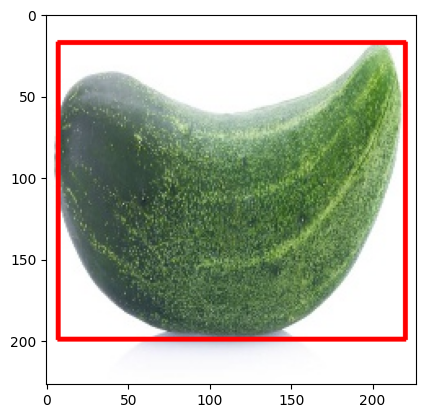

In [ ]:
row=df.iloc[18]
img=cv2.imread(DATA_DIR+'/'+row.img_path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1=(row.xmin, row.ymin)
pt2=(row.xmax, row.ymax)
bnd_box_image=cv2.rectangle(img, pt1,pt2,(255,0,0), 2)

plt.imshow(bnd_box_image)

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_aug=A.Compose([
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_aug=A.Compose([
        A.Resize(IMG_SIZE,IMG_SIZE)

],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations=None):
     self.df=df
     self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
     row = self.df.iloc[idx]

     xmin=row.xmin
     ymin=row.ymin
     xmax=row.xmax
     ymax=row.ymax

     bbox=[[xmin,ymin,xmax,ymax]]

     img_path= DATA_DIR +'/'+ row.img_path
     img=cv2.imread(img_path)
     img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

     if self.augmentations:
        data=self.augmentations(image=img, bboxes=bbox, class_labels=[None])
        img=data['image']
        bbox=data['bboxes'][0]

     img=torch.from_numpy(img).permute(2,0,1)/255.0
     bbox=torch.Tensor(bbox)

     return img, bbox




In [ ]:
trainset=ObjLocDataset(train_df, train_aug)
validset=ObjLocDataset(valid_df, valid_aug)

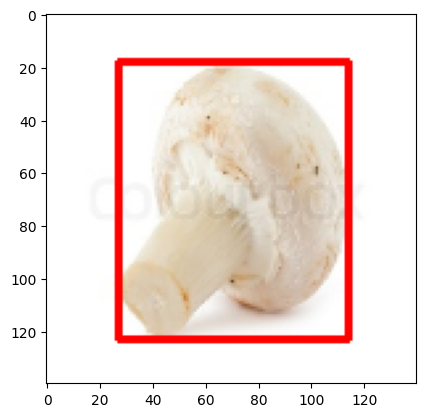

In [ ]:
img, bbox = trainset[18]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader=torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images,bbox in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bbox.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self):
     super(ObjLocModel, self).__init__()

     self.backbone=timm.create_model(MADEL_NAME, pretrained=True, num_classes=4)

  def forward(self,images, gt_bboxes=None):

    bboxes=self.backbone(images)

    if gt_bboxes !=None:
      loss=nn.MSELoss()(bboxes, gt_bboxes)

      return bboxes,loss
    return bboxes

In [ ]:
model=ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img=torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss=0.0
  model.train()#Dropout ON

  for data in tqdm(dataloader):
    images,gt_bboxes=data
    images,gt_bboxes=images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss =model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
def val_fn(model, dataloader):
  total_loss=0.0
  model.eval()#Dropout OF

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,gt_bboxes=data
      images,gt_bboxes=images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss =model(images, gt_bboxes)

      total_loss += loss.item()

    return total_loss/len(dataloader)

#Training Loop

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss=np.inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss= val_fn(model, validloader)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHTS ARE SAVED")
    best_valid_loss=valid_loss

  print(f"Epoch:{i+1} train loss: {train_loss} valid loss:{valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:1 train loss: 7443.7326171875 valid loss:6935.390625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:2 train loss: 7069.227001953125 valid loss:5818.485188802083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:3 train loss: 6151.51181640625 valid loss:3755.9945475260415


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:4 train loss: 4786.380590820312 valid loss:2576.33740234375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:5 train loss: 3319.36572265625 valid loss:1350.5277506510417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:6 train loss: 1705.1627319335937 valid loss:907.2660929361979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:7 train loss: 581.2487060546875 valid loss:604.4642537434896


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:8 train loss: 263.4295166015625 valid loss:317.03184000651044


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:9 train loss: 219.8136749267578 valid loss:301.84385681152344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:10 train loss: 224.37993774414062 valid loss:287.98553466796875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:11 train loss: 192.39691009521485 valid loss:334.15960693359375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:12 train loss: 194.63268280029297 valid loss:246.50669860839844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:13 train loss: 161.31475753784179 valid loss:256.2610778808594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:14 train loss: 168.2529098510742 valid loss:216.0186309814453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:15 train loss: 166.3282012939453 valid loss:202.80094401041666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:16 train loss: 148.29365081787108 valid loss:173.4662119547526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:17 train loss: 134.88973999023438 valid loss:157.69113159179688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:18 train loss: 135.3634490966797 valid loss:156.25761922200522


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:19 train loss: 146.7234794616699 valid loss:145.7296396891276


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:20 train loss: 107.49827423095704 valid loss:132.91148885091147


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:21 train loss: 105.2466812133789 valid loss:133.94935862223306


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:22 train loss: 101.19754219055176 valid loss:125.25606791178386


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:23 train loss: 96.13595237731934 valid loss:119.42322540283203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:24 train loss: 93.63458251953125 valid loss:112.7995376586914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:25 train loss: 105.63500213623047 valid loss:102.77266184488933


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:26 train loss: 92.66215744018555 valid loss:101.05820210774739


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:27 train loss: 97.7808177947998 valid loss:119.7509053548177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:28 train loss: 86.48667449951172 valid loss:106.57847595214844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:29 train loss: 80.52990798950195 valid loss:98.7212651570638


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:30 train loss: 70.95039291381836 valid loss:92.12508392333984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:31 train loss: 75.16946716308594 valid loss:105.59896087646484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:32 train loss: 66.24646835327148 valid loss:92.15865834554036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:33 train loss: 71.61138496398925 valid loss:81.6064682006836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:34 train loss: 77.22508392333984 valid loss:83.88843790690105


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:35 train loss: 75.54248428344727 valid loss:87.29459635416667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:36 train loss: 62.928619384765625 valid loss:95.53514862060547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:37 train loss: 73.53176651000976 valid loss:75.93216196695964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:38 train loss: 63.817266845703124 valid loss:105.07623291015625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:39 train loss: 62.30605773925781 valid loss:101.93314615885417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:40 train loss: 75.77357559204101 valid loss:113.67717997233073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:41 train loss: 71.37568283081055 valid loss:121.30079905192058


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:42 train loss: 57.47232933044434 valid loss:132.7862548828125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:43 train loss: 62.89034881591797 valid loss:103.87522379557292


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:44 train loss: 65.78617095947266 valid loss:84.16626485188802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:45 train loss: 49.94531326293945 valid loss:103.42367299397786


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:46 train loss: 52.75649852752686 valid loss:85.08196258544922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:47 train loss: 47.608788299560544 valid loss:71.45549774169922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:48 train loss: 57.03503837585449 valid loss:71.2381820678711


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:49 train loss: 48.863319396972656 valid loss:58.06987762451172


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:50 train loss: 50.996513748168944 valid loss:82.04591369628906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:51 train loss: 48.29755878448486 valid loss:53.46116828918457


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:52 train loss: 43.98968296051025 valid loss:48.28051439921061


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:53 train loss: 39.65949459075928 valid loss:48.184329986572266


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:54 train loss: 31.190992546081542 valid loss:43.92725626627604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:55 train loss: 34.96590023040771 valid loss:41.762393951416016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:56 train loss: 32.55965728759766 valid loss:49.36752446492513


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:57 train loss: 42.81043291091919 valid loss:43.91824086507162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:58 train loss: 41.81316032409668 valid loss:46.59601084391276


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:59 train loss: 37.755923461914065 valid loss:40.46388244628906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:60 train loss: 33.53333683013916 valid loss:47.82776006062826


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:61 train loss: 28.723493003845213 valid loss:43.876258850097656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:62 train loss: 35.530433177948 valid loss:35.494188944498696


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:63 train loss: 27.372678756713867 valid loss:64.87276713053386


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:64 train loss: 41.575469970703125 valid loss:36.686485290527344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:65 train loss: 37.20076236724854 valid loss:55.82095464070638


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:66 train loss: 30.38291883468628 valid loss:48.62758827209473


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:67 train loss: 26.455474853515625 valid loss:59.13396453857422


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:68 train loss: 36.82136917114258 valid loss:35.66415532430013


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:69 train loss: 30.734090423583986 valid loss:41.442849477132164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:70 train loss: 39.99868640899658 valid loss:42.26082992553711


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:71 train loss: 30.504606246948242 valid loss:35.679726918538414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:72 train loss: 23.762713813781737 valid loss:38.1820437113444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch:73 train loss: 31.232547950744628 valid loss:32.98440424601237


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:74 train loss: 30.72234115600586 valid loss:43.07536951700846


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:75 train loss: 33.80597915649414 valid loss:46.216681162516274


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:76 train loss: 43.65320739746094 valid loss:42.79096476236979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:77 train loss: 25.443791389465332 valid loss:46.13215764363607


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:78 train loss: 24.765391254425047 valid loss:37.877062479654946


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:79 train loss: 39.6976095199585 valid loss:38.251416524251304


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:80 train loss: 28.565023994445802 valid loss:46.41046396891276


#Inference

In [ ]:
import utils

<ipython-input-138-641f1d5a0274>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Green: Actual Bounding box
Red: Predicted Bounding box


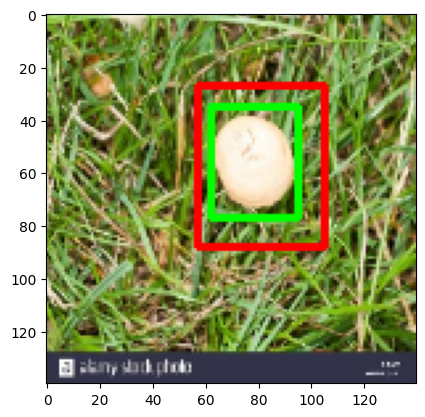

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image,gt_bbox=validset[10]#(c,h,w)
  images=image.unsqueeze(0).to(DEVICE) #(bs,c,h,w)
  out_bbox=model(images)

  print("\033[1;92mGreen:\033[1;92m Actual Bounding box")  # Bold Green
  print("\033[1;91mRed:\033[2m Predicted Bounding box")  # Bold Red


  utils.compare_plots(image, gt_bbox, out_bbox)